In [31]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
cd /content/gdrive/MyDrive/DlClass

/content/gdrive/MyDrive/DlClass


In [35]:
ls

1_classification/  3_yolo/                ObjectDetection-YOLO.zip  run3.mp4
2_ssd/             ObjectDetection-YOLO/  pytorch-ssd/


In [36]:
cd ObjectDetection-YOLO/

/content/gdrive/My Drive/DlClass/ObjectDetection-YOLO


In [37]:
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path

# Initialize the parameters
confThreshold = 0.95  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image


In [38]:
tiny=1

In [ ]:
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
if (tiny == 1):
    modelConfiguration = "yolov3-tiny.cfg"
    modelWeights = "yolov3-tiny.weights"
    print('tiny !!!')  
else:
    modelConfiguration = "yolov3.cfg"
    modelWeights = "yolov3.weights"


tiny !!!


In [39]:
net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)
print('Using CPU device.')


Using CPU device.


In [40]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(frame, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv.FILLED)
    cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)


In [41]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))

                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        #print('i{} conf{}'.format(i,confidences[i] ))
        if(i == 0):
            XPos = left + width/2
            YPos = top + height/2
            print('XPos{} YPos{}'.format(XPos, YPos ))
        drawPred(frame, classIds[i], confidences[i], left, top, left + width, top + height)


In [42]:
def frame_infer(frame):
        blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))
        # Remove the bounding boxes with low confidence
        postprocess(frame, outs)

        # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
        t, _ = net.getPerfProfile()
        label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
        cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))   
        return frame 

In [43]:
def imagefile_infer2(imagename):
    if not os.path.isfile(imagename):
        print("Input image file ", imagename, " doesn't exist")
        sys.exit(1)
    print("Input image file ", imagename)
    cap = cv.VideoCapture(imagename)
    if (tiny == 1):
        outputFile = imagename[:-4]+'_carteset_tiny.jpg'
    else:
        outputFile = imagename[:-4]+'_cartest.jpg'

    frame = None
    hasFrame, frame = cap.read()
    if not hasFrame:
        print("no frame !!!")

    else :
        print("has frame !!!")

        outframe = frame_infer(frame)
        print('infer success outframe')

        # Write the frame with the detection boxes
        cv.imwrite(outputFile, outframe.astype(np.uint8))    

    cap.release()


In [45]:
imagefile_infer2('car.jpg')

Input image file  car.jpg
has frame !!!
infer success outframe


In [46]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(width, height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(9, 5)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [47]:
ls

accident2.mp4          coco.names                   README.md
accident.mp4           getModels.sh                 run3.mp4
bird.jpg               how_to_download_weights.txt  yolov3.cfg
bird_yolo_out.jpg      LICENSE                      yolov3-tiny.cfg
bird_yolotiny_out.jpg  object_detection2.py         yolov3-tiny.weights
car_carteset_tiny.jpg  object_detection_yolo.cpp    yolov3.weights
car.jpg                object_detection_yolo.py
CMakeLists.txt         people.mp4


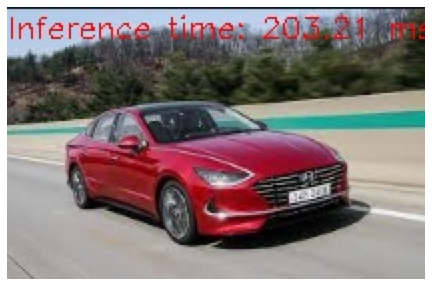

In [48]:
imShow('car_carteset_tiny.jpg')

In [49]:
import cv2
from IPython.display import display, Image
import time

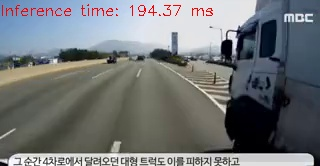

XPos34.0 YPos83.5
XPos34.0 YPos83.5
XPos32.5 YPos85.0
XPos32.5 YPos85.0
Done processing !!!


In [50]:
path='accident.mp4'
fps = 60

cap = cv2.VideoCapture(path)
display_handle=display(None, display_id=True)
try:
    if cap.isOpened(): 
        while cap.isOpened():
            hasFrame, frame = cap.read()
    
            # Stop the program if reached end of video
            if not hasFrame:
                print("Done processing !!!")    
                cv.waitKey(3000)
                # Release device
                cap.release()
                break
            width=360
            height=224
            outframe = frame_infer(frame)
            _, outframe = cv2.imencode('.jpeg', outframe)
            display_handle.update(Image(data=outframe.tobytes()))

except KeyboardInterrupt:
    pass
finally:
    cap.release()
    #display_handle.update(None)

* Calulate Distance 

In [51]:
def frameShow(image):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(width, height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [52]:
import numpy as np
import math
import cv2

### Camera coordinate to vehicle coordinate(ISO)
def RotX(Pitch):
      Pitch = np.deg2rad(Pitch)
      return [[1, 0, 0], [0, math.cos(Pitch), -math.sin(Pitch)], [0, math.sin(Pitch), math.cos(Pitch)]]

def RotY(Yaw):
      Yaw = np.deg2rad(Yaw)
      return [[math.cos(Yaw), 0, math.sin(Yaw)], [0, 1, 0], [-math.sin(Yaw), 0, math.cos(Yaw)]]

def RotZ(Roll):
      Roll = np.deg2rad(Roll)
      return [[math.cos(Roll), -math.sin(Roll), 0], [math.sin(Roll), math.cos(Roll), 0], [0, 0, 1]]      


In [53]:
### Camera parameter setting
ImageSize = (480, 640)
FocalLength = (309.4362, 344.2161)
PrinciplePoint = (318.9034, 257.5352)
IntrinsicMatrix = ((FocalLength[0], 0, 0), (0, FocalLength[1], 0), (PrinciplePoint[0], PrinciplePoint[1], 1))
Height = 2.1798
Pitch = 14
Yaw = 0
Roll = 0


In [54]:
### Bird's eye view setting
DistAhead = 30
SpaceToOneSide = 6
BottomOffset = 3.0

OutView = (BottomOffset, DistAhead, -SpaceToOneSide, SpaceToOneSide)
OutImageSize = [math.nan, 250]

WorldHW = (abs(OutView[1]-OutView[0]), abs(OutView[3]-OutView[2]))

Scale = (OutImageSize[1]-1)/WorldHW[1]
ScaleXY = (Scale, Scale)

OutDimFrac = Scale*WorldHW[0]
OutDim = round(OutDimFrac)+1
OutImageSize[0] = OutDim

### Homography Matrix Compute

#Translation Vector
Rotation = np.matmul(np.matmul(RotZ(-Yaw),RotX(90-Pitch)),RotZ(Roll))
TranslationinWorldUnits = (0, 0, Height)
Translation = [np.matmul(TranslationinWorldUnits, Rotation)]

#Rotation Matrix
RotationMatrix = np.matmul(RotY(180), np.matmul(RotZ(-90), np.matmul(RotZ(-Yaw), np.matmul(RotX(90-Pitch), RotZ(Roll)))))

#Camera Matrix
CameraMatrix = np.matmul(np.r_[RotationMatrix, Translation], IntrinsicMatrix)
CameraMatrix2D = np.r_[[CameraMatrix[0]], [CameraMatrix[1]], [CameraMatrix[3]]]

#Compute Vehicle-to-Image Projective Transform
VehicleHomo = np.linalg.inv(CameraMatrix2D)

AdjTransform = ((0, -1, 0), (-1, 0, 0), (0, 0, 1))
BevTransform = np.matmul(VehicleHomo, AdjTransform)

DyDxVehicle = (OutView[3], OutView[1])
tXY = [a*b for a,b in zip(ScaleXY, DyDxVehicle)]

#test = np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])
ViewMatrix = ((ScaleXY[0], 0, 0), (0, ScaleXY[1], 0), (tXY[0]+1, tXY[1]+1, 1))

T_Bev = np.matmul(BevTransform, ViewMatrix)
T_Bev = np.transpose(T_Bev)


In [57]:
ls testImage.jpg

testImage.jpg


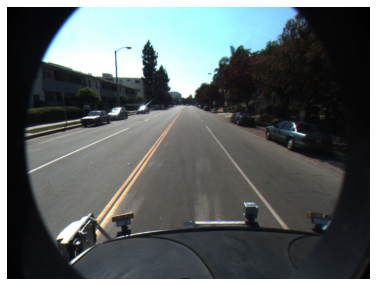

In [58]:
imShow('testImage.jpg')

10.77


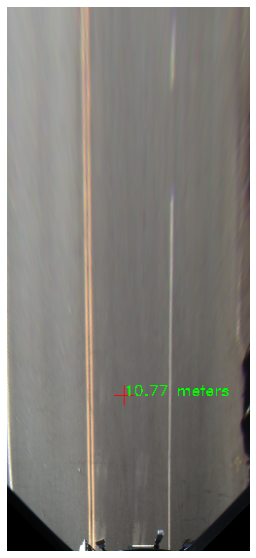

In [59]:
### Main
src = cv2.imread("testImage.jpg", cv2.IMREAD_COLOR)

BirdEyeView = cv2.warpPerspective(src, T_Bev, (OutImageSize[1], OutImageSize[0]))
#Image to Vehicle
toOriginalImage = np.linalg.inv(np.transpose(T_Bev))
Trans = np.matmul(toOriginalImage, VehicleHomo)
ImagePoint = [[120, 400]]

UI = ImagePoint
UI = np.r_[ImagePoint[0], np.shape(ImagePoint)[0]]
XI = np.matmul(UI, Trans)

XI[0:2] = XI[0:2]/XI[2]
XAhead = XI[0]

tp = tuple(ImagePoint[0])
#print(tp)
dist = round(XAhead, 2)
annotatedBEV2 = cv2.drawMarker(BirdEyeView, tp, (0,0,255))
cv2.putText(annotatedBEV2, str(dist)+" meters", tp, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,255,0))
print(dist)
frameShow(annotatedBEV2)

Make Function !!

In [102]:
def get_distance(frame, xpos, ypos, show):
    ### Main
    #src = cv2.imread("testImage.jpg", cv2.IMREAD_COLOR)
    xpos = int(xpos)
    ypos = int(ypos)
    height = frame.shape[0]
    print(height)
    ypos = height - ypos 
 
    BirdEyeView = cv2.warpPerspective(frame, T_Bev, (OutImageSize[1], OutImageSize[0]))
    #Image to Vehicle
    toOriginalImage = np.linalg.inv(np.transpose(T_Bev))
    Trans = np.matmul(toOriginalImage, VehicleHomo)
    ImagePoint=[[xpos, ypos]]
    
    UI = ImagePoint
    UI = np.r_[ImagePoint[0], np.shape(ImagePoint)[0]]
    XI = np.matmul(UI, Trans)
    
    XI[0:2] = XI[0:2]/XI[2]
    XAhead = XI[0]
    
    tp = tuple(ImagePoint[0])
    dist = round(XAhead, 2)

    if (show==1):    
        annotatedBEV2 = cv2.drawMarker(BirdEyeView, tp, (0,0,255))
        point=(10, 10)
        cv2.putText(annotatedBEV2, str(dist)+" meters", point, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,255,0))

        frameShow(annotatedBEV2)

    return dist


480


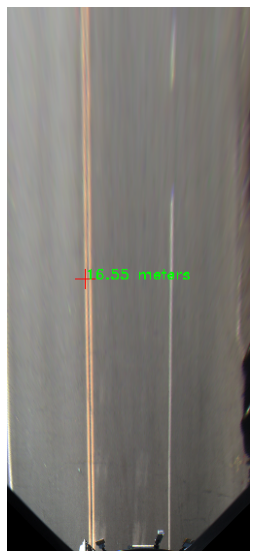

16.55


In [95]:
frame = cv2.imread("testImage.jpg", cv2.IMREAD_COLOR)
dist = get_distance(frame, 80, 200, 1)
print(dist)

In [ ]:
ls

accident2.mp4          dl_data.zip                   run2.mp4
accident.mp4           drivingcar_carteset_tiny.jpg  run.mp4
aeb.mp4                drivingcar.jpg                testImage.jpg
car_carteset_tiny.jpg  fc1.mp4                       yolov3.cfg
car.jpg                fc2.mp4                       yolov3-tiny.cfg
car_yolo_out.jpg       getModels.sh                  yolov3-tiny.weights
car_yolotiny_out.jpg   how_to_download_weights.txt   yolov3.weights
coco.names             object_detection_yolo.py


In [96]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess2(frame, outs, getDist):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))

                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        #print('i{} conf{}'.format(i,confidences[i] ))
        if(i == 0):
            XPos = left + width/2
            YPos = top + height/2
            if getDist == 1:
                dist = get_distance(frame, XPos, YPos, 0)
                print('Distance:{} XPos:{} YPos:{}'.format(dist, XPos, YPos ))
                cv2.putText(frame, str(dist)+" meters", tp, cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,255,0))
            else:
                print('XPos:{} YPos:{}'.format(XPos, YPos ))
                drawPred(frame, classIds[i], confidences[i], left, top, left + width, top + height)

In [98]:
def frame_infer2(frame):
        blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))
        # Remove the bounding boxes with low confidence
        postprocess2(frame, outs, 1)

        # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
        t, _ = net.getPerfProfile()
        label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
        cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))   
        return frame 

In [100]:
ls run3.mp4

run3.mp4


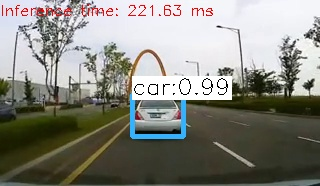

186
Distance:26.67 XPos:164.5 YPos:116.5
186
Distance:26.67 XPos:164.5 YPos:116.5
186
Distance:26.67 XPos:165.0 YPos:116.5
186
Distance:26.67 XPos:165.5 YPos:116.5
186
Distance:26.67 XPos:165.0 YPos:116.5
186
Distance:26.67 XPos:165.5 YPos:116.5
186
Distance:26.77 XPos:166.0 YPos:118.0
186
Distance:26.72 XPos:166.0 YPos:117.5
186
Distance:26.77 XPos:165.0 YPos:118.0
186
Distance:26.82 XPos:164.5 YPos:119.0
186
Distance:26.77 XPos:163.5 YPos:118.5
186
Distance:26.77 XPos:164.0 YPos:118.5
186
Distance:26.77 XPos:163.5 YPos:118.5
186
Distance:26.72 XPos:162.5 YPos:117.5
186
Distance:26.72 XPos:163.0 YPos:117.5
186
Distance:26.67 XPos:162.0 YPos:116.5
186
Distance:26.72 XPos:162.5 YPos:117.0
186
Distance:26.67 XPos:161.5 YPos:116.5
186
Distance:26.67 XPos:163.0 YPos:116.5
186
Distance:26.67 XPos:162.0 YPos:116.5
186
Distance:26.67 XPos:161.5 YPos:116.5
186
Distance:26.67 XPos:162.0 YPos:116.0
186
Distance:26.63 XPos:161.5 YPos:115.5
186
Distance:26.67 XPos:161.5 YPos:116.0
186
Distance:26.

In [ ]:
path='run3.mp4'
fps = 60

cap = cv2.VideoCapture(path)
display_handle=display(None, display_id=True)
try:
    if cap.isOpened(): 
        while cap.isOpened():
            hasFrame, frame = cap.read()
    
            # Stop the program if reached end of video
            if not hasFrame:
                print("Done processing !!!")    
                cv.waitKey(3000)
                # Release device
                cap.release()
                break
            width=360
            height=224
            outframe = frame_infer2(frame)
            _, outframe = cv2.imencode('.jpeg', outframe)
            display_handle.update(Image(data=outframe.tobytes()))

except KeyboardInterrupt:
    pass
finally:
    cap.release()
    #display_handle.update(None)